# 5) Application de modèles d'apprentissage supervisé

Dans la partie précédente, nous avons utilisé des modèles d'apprentissage non-superviés afin de dégager les mots les plus utilisés dans les mails. Depuis ces mots, nous avons classer nos mails en 4 thèmes: Meetings (si le mail évoque les mots "meeting" ou "presenter"), Business Trip (si le mail évoque les mots "flying", "traveling" ou "trip") , Hobby ( pour les mots "ski", "golf", "boat"), ou Autre pour les autres mails.

Dans cette partie, nous allons appliquer des modèles d'apprentissage supervisé pour le thème d'un mail en s'appuyant sur les variables que nous avons créées : Moment,Day,Month,subject_size,content_size,forwarded_mail,nb_cc
Nous comparerons l'efficacité de nos modèles à l'aide de deux indicateurs, l'accuracy (taux de justesse) et le recall (rappel) en priorisant ce dernier.

In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import time
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
dataset = pd.read_csv('/Users/pierreperrin/Desktop/IG4/semestre7/Projet_DataScience/dataset_cleaned.csv',
                      dtype={"content": str},low_memory=False)
df = dataset[['Moment','Day','Month','subject_size','content_size','forwarded_mail','nb_cc','Meetings']]
df.head()

,Moment,Day,Month,subject_size,content_size,forwarded_mail,nb_cc,Meetings
0,3,14,5,0,20,0,0,0
1,3,4,5,3,773,0,0,1
2,1,18,10,8,29,0,0,0
3,2,23,10,0,180,0,0,0
4,2,31,8,9,33,0,0,0


## Classer un mail en "Meetings"
Nous allons ici prédir si un mail évoque une réunion en utilisant différents modèles non-supervisés. On sépare donc notre jeu de données en 2. Une partie qui va nous servir à apprendre à nos modèles à classer correctement si mail concerne une réunion (X_train, y_train) et une partie qui va nous permettre à tester notre modèle (X_test,y_test).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
X = df.drop(['Meetings'], axis=1)
y = df['Meetings']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Modèle 1 : KNeighborsClassifier

In [3]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.842

Le modèle des KNeighborsClassifier prédit qu'un mail concerne une réunion un taux de justesse de 84%
La métric que l'on décide de choisir pour tester notre modèle est le recall puisque que l'on a à peu près 20 % (un peu moins) de mails qui appartiennent aux thème meeting et 80% non. De ce fait si on regardait la métrique accuracy, cela ne serait pas pertinent puisque notre modele n'a qu'a attribuer la classe non meeting a tout les mails et il aura une accuracy de 80%.

On utilise la methode stratifiedKfold pour creer des splits de données sur lesquels on entraine notre modèle. Cette methode consiste donc à créer des slpits dans lesquels on va avoir à chaque fois une petite portion de chacune de nos classes. Cela parrait necessaire pour notre dataset assez desequilibré (80% des mails n'appartenant pas à la classe meetings). Cette methode assurera donc que dans un split de donnée on ne se retrouve pas avec une seule classe représentée lorsque l'on effectuera la cross-validation, sinon nos resultats serait faussés.

In [4]:
kfold = StratifiedKFold(n_splits=20, random_state=1, shuffle=True)
cv_results = cross_val_score(KNeighborsClassifier(), X_train, y_train, cv=kfold, scoring='recall')
print("recall :",cv_results.mean())

recall : 0.3884747299775831


notre remarque très clairement que notre recall est peu satsfaisant dans ce cas

In [5]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

model1 = KNeighborsClassifier()
model1 = model1.fit(X_train, y_train)
predictions1 = model1.predict(X_test)

print(accuracy_score(y_test, predictions1))
print(confusion_matrix(y_test, predictions1))
print(classification_report(y_test, predictions1))

0.842
[[15422  1041]
 [ 2119  1418]]
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     16463
           1       0.58      0.40      0.47      3537

    accuracy                           0.84     20000
   macro avg       0.73      0.67      0.69     20000
weighted avg       0.83      0.84      0.83     20000



### Amélioration du modèle des KNeighborsClassifier

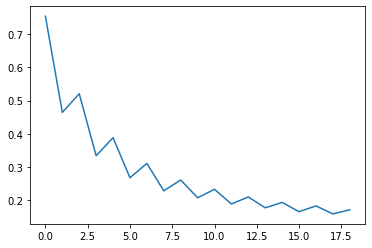

In [6]:
val_score = []
for k in range(1,20):
    score = cross_val_score(KNeighborsClassifier(k), X_train, y_train, cv = kfold, scoring='recall').mean()
    val_score.append(score)

plt.plot(val_score)

ce graphe ne permet pas de dégager de valeur particulière pour le paramètre k de la fonction KNeighborsClassifier pour lequel le score serait plus important 

In [7]:
param_grid = {'n_neighbors': np.arange(1,20), 'metric': ['euclidean', 'manhattan']}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)

grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])})

In [8]:
grid.best_score_

0.8995124999999999

In [9]:
grid.best_estimator_

KNeighborsClassifier(metric='manhattan', n_neighbors=1)

In [10]:
model = grid.best_estimator_
model.score(X_test, y_test)

0.9231

In [11]:
confusion_matrix(y_test, model.predict(X_test))

array([[15744,   719],
       [  819,  2718]])

On a donc réussis à ameliorer notre model en regardant cette matrice de confusion

In [12]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95     16463
           1       0.79      0.77      0.78      3537

    accuracy                           0.92     20000
   macro avg       0.87      0.86      0.87     20000
weighted avg       0.92      0.92      0.92     20000



Finalement, après amélioration le modèle KNeighborsClassifier permet de classer si un mail concerne une réunion avec un taux de 
justesse de 0,92. Un rappel pour classer un mail comme de 0,77 pour vrai et 0,95 pour faux. Ces résultats sont globalement satisfaisant et le modèle nous parait éfficace pour classer la modalité Meetings d'un mail.


### Modèle 2 : Decision Tree

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

kfold = StratifiedKFold(n_splits=20, random_state=1, shuffle=True)
cv_results = cross_val_score(DecisionTreeClassifier(), X_train, y_train, cv=kfold, scoring='recall')
print("recall :",cv_results.mean())


recall : 0.7737333401263502


In [14]:
model2 = tree.DecisionTreeClassifier()
model2 = model2.fit(X_train, y_train)
predictions2 = model2.predict(X_test)

print(accuracy_score(y_test, predictions2))
print(confusion_matrix(y_test, predictions2))
print(classification_report(y_test, predictions2))

#max_depth
#tree.plot_tree(model2) 

0.91895
[[15618   845]
 [  776  2761]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     16463
           1       0.77      0.78      0.77      3537

    accuracy                           0.92     20000
   macro avg       0.86      0.86      0.86     20000
weighted avg       0.92      0.92      0.92     20000



L'arbre de décision a un taux de justesse de 0.90, a un rappel de 0,94 pour l'étiquette faux et 0,75 pour l'étiquette vrai. Ces résultats nous semble également satisfaisant pour prevoir la modalité Meetings d'un mail.

### Modèle 3 : SVC

In [15]:
from sklearn.svm import LinearSVC

kfold = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
cv_results = cross_val_score(LinearSVC(), X_train, y_train, cv=kfold, scoring='recall')
print("recall :",cv_results.mean())


/Users/pierreperrin/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/pierreperrin/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/pierreperrin/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/pierreperrin/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


recall : 0.13173840993364


/Users/pierreperrin/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [16]:
model3 = LinearSVC()
model3 = model3.fit(X_train, y_train)
predictions3 = model3.predict(X_test)

print(accuracy_score(y_test, predictions3))
print(confusion_matrix(y_test, predictions3))
print(classification_report(y_test, predictions3))

0.82315
[[16463     0]
 [ 3537     0]]
              precision    recall  f1-score   support

           0       0.82      1.00      0.90     16463
           1       0.00      0.00      0.00      3537

    accuracy                           0.82     20000
   macro avg       0.41      0.50      0.45     20000
weighted avg       0.68      0.82      0.74     20000



/Users/pierreperrin/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/pierreperrin/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Le modèle SVC a un taux de justesse de 0.82, un rappel de 1 pour l'étiquette faux et 0.05 pour l'étiquette vrai. Le modèle a tendance classer tout les mails comme faux. Ces résultats ne nous semble pas assez satisfaisant pour classer la modalité Meetings d'un mail.

# Classer un mail en "Business Trip"

In [17]:
df = dataset[['Moment','subject_size','content_size','forwarded_mail','nb_cc','Meetings']]

### Modèle 1 : KNeighborsClassifier

In [18]:
model_Business_trip = KNeighborsClassifier()
model_Business_trip.fit(X_train, y_train)
model_Business_trip.score(X_test, y_test)

0.842

In [19]:
df2 = dataset[['Moment','Day','Month','subject_size','content_size','forwarded_mail','nb_cc','Business_trip']]

In [20]:
X = df2.drop(['Business_trip'], axis=1)
y = df2['Business_trip']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [22]:
model2_1 = KNeighborsClassifier()
model2_1.fit(X_train, y_train)
model2_1.score(X_test, y_test)

0.92955

In [23]:
kfold = StratifiedKFold(n_splits=20, random_state=1, shuffle=True)
cv_results = cross_val_score(KNeighborsClassifier(), X_train, y_train, cv=kfold, scoring='recall')

In [24]:
print("recall :",cv_results.mean())

recall : 0.3300629130655821


In [25]:
predictions2_1 = model2_1.predict(X_test)

print(accuracy_score(y_test, predictions2_1))
print(confusion_matrix(y_test, predictions2_1))
print(classification_report(y_test, predictions2_1))

0.92955
[[18145   504]
 [  905   446]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     18649
           1       0.47      0.33      0.39      1351

    accuracy                           0.93     20000
   macro avg       0.71      0.65      0.68     20000
weighted avg       0.92      0.93      0.92     20000



Le modèle KNeighborsClassifier a un taux de justesse de 0.93, a un rappel de 0,98 pour l'étiquette faux mais seulement  0,33 pour l'étiquette vrai. Cela parait normal puisque notre dataset est constitué majoritairement de mails qui n'evoquent pas les réunions (environ 80%). Ces résultats sont insatifaisant pour le classer un mail en Business Trip 

In [26]:
param_grid = {'n_neighbors': np.arange(1,20), 'metric': ['euclidean', 'manhattan']}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)

grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])})

In [27]:
grid.best_score_

0.9550375000000001

In [28]:
grid.best_estimator_

KNeighborsClassifier(metric='euclidean', n_neighbors=1)

In [29]:
model = grid.best_estimator_
model.score(X_test, y_test)

0.96355

In [30]:
confusion_matrix(y_test, model.predict(X_test))

array([[18267,   382],
       [  347,  1004]])

In [84]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.30      0.12      0.17      3434
           2       0.00      0.00      0.00       947
           3       0.00      0.00      0.00      2115
           4       0.00      0.00      0.00     13504

    accuracy                           0.02     20000
   macro avg       0.06      0.02      0.03     20000
weighted avg       0.05      0.02      0.03     20000



/Users/pierreperrin/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pierreperrin/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Colonne thèmes

In [31]:
#on va classer les mails par theme, pour cela on etablit on ordre d'importance lorsque 
#le mail parle de différent theme puisqu'on doit le classer que dans un seul theme

def theme(dataset):
    
    dataset['theme'] = None
    
    for i in range(len(dataset.content)):
        if (dataset['Meetings'][i]==1):
            dataset['theme'][i] = 1
        elif (dataset['Business_trip'][i]==1):
            dataset['theme'][i] = 2
        elif(dataset['hobby'][i]==1):
            dataset['theme'][i] = 3
        else:
            dataset['theme'][i] = 4

            
theme(dataset)

<ipython-input-31-d99cc955d317>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['theme'][i] = 4
<ipython-input-31-d99cc955d317>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['theme'][i] = 1
<ipython-input-31-d99cc955d317>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['theme'][i] = 3
<ipython-input-31-d99cc955d317>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

In [32]:
print(dataset[dataset['theme']==1].shape)
print(dataset[dataset['theme']==2].shape)
print(dataset[dataset['theme']==3].shape)
print(dataset[dataset['theme']==4].shape)

(17543, 30)
(4839, 30)
(10370, 30)
(67248, 30)


# Classification des mails par thèmes :

On a ensuite décider d'essayer de classer nos mails plus généralement dans un thème après la création de la colonne "theme".

In [33]:
df3 = dataset[['Moment','Day','Month','subject_size','content_size','forwarded_mail','nb_cc','theme']]
df3.head()

,Moment,Day,Month,subject_size,content_size,forwarded_mail,nb_cc,theme
0,3,14,5,0,20,0,0,4
1,3,4,5,3,773,0,0,1
2,1,18,10,8,29,0,0,4
3,2,23,10,0,180,0,0,4
4,2,31,8,9,33,0,0,4


In [53]:
X = df3.drop(['theme'], axis=1)
y = df3['theme']
y=y.astype('int')

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


43731    3
86701    1
19210    3
84099    4
68794    4
        ..
54995    4
5947     4
56001    4
87306    4
42064    4
Name: theme, Length: 20000, dtype: int64

In [56]:
model3_1 = KNeighborsClassifier()
model3_1.fit(X_train, y_train)
model3_1.score(X_test, y_test)

0.71195

In [67]:
kfold = StratifiedKFold(n_splits=20, random_state=1, shuffle=True)
cv_results = cross_val_score(KNeighborsClassifier(), X_train, y_train, cv=kfold, scoring='accuracy')

In [68]:
print("accuracy :",cv_results.mean())

recall : 0.7095875


In [70]:
predictions3_1 = model3_1.predict(X_test)

print(accuracy_score(y_test, predictions3_1))
print(confusion_matrix(y_test, predictions3_1))
print(classification_report(y_test, predictions3_1))

0.71195
[[ 1635   155   261  1383]
 [  186   312    80   369]
 [  457   126   729   803]
 [ 1081   257   603 11563]]
              precision    recall  f1-score   support

           1       0.49      0.48      0.48      3434
           2       0.37      0.33      0.35       947
           3       0.44      0.34      0.38      2115
           4       0.82      0.86      0.84     13504

    accuracy                           0.71     20000
   macro avg       0.53      0.50      0.51     20000
weighted avg       0.70      0.71      0.71     20000



On peut voir le score de la cross_validation qui est assez proche du score sur le test ce qui signifie que notre modèle semble bien généraliser les données. On peut voir que la 4eme classe est beaucoup mieux prédite que les autres. Cela s'explique par le fait que notre dataset est assez déséquilibré puisqu'il est composé de plus de 50% de mail appartenant à la 4eme classe (autre).

#### Le recall est trop petit donc la methode des KNNeighbours n'est pas bonne pour cette classification

#### on essaie donc par la suite le modèle DecisionTreeClassifier

# Decision tree

In [71]:
kfold = StratifiedKFold(n_splits=20, random_state=1, shuffle=True)
cv_results = cross_val_score(DecisionTreeClassifier(), X_train, y_train, cv=kfold, scoring='accuracy')
print("accuracy :",cv_results.mean())

accuracy : 0.8520875


In [72]:
model3_2 = tree.DecisionTreeClassifier()
model3_2 = model3_2.fit(X_train, y_train)
predictions3_2 = model3_2.predict(X_test)

print(accuracy_score(y_test, predictions3_2))
print(confusion_matrix(y_test, predictions3_2))
print(classification_report(y_test, predictions3_2))

0.86495
[[ 2692    63   107   572]
 [   54   679    47   167]
 [  145    62  1580   328]
 [  614   151   391 12348]]
              precision    recall  f1-score   support

           1       0.77      0.78      0.78      3434
           2       0.71      0.72      0.71       947
           3       0.74      0.75      0.75      2115
           4       0.92      0.91      0.92     13504

    accuracy                           0.86     20000
   macro avg       0.79      0.79      0.79     20000
weighted avg       0.87      0.86      0.87     20000



De la même manière on observe que la cross_validation est aussi très proche du score sur le test. on voit que les 3 premières classes sont beacoup mieux prédites que le modèle précédent avec un recall superieur à 0,70. 

# RandomForestClassifier

In [80]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [81]:
model3_2 = RandomForestClassifier()
model3_2.fit(X_train, y_train)
model3_2.score(X_test, y_test)

0.9026

In [82]:
kfold = StratifiedKFold(n_splits=20, random_state=1, shuffle=True)
cv_results = cross_val_score(RandomForestClassifier(), X_train, y_train, cv=kfold, scoring='accuracy')
print("accuracy :",cv_results.mean())

accuracy : 0.8961625


In [83]:
model3_2 = RandomForestClassifier()
model3_2 = model3_2.fit(X_train, y_train)
predictions3_2 = model3_2.predict(X_test)

print(accuracy_score(y_test, predictions3_2))
print(confusion_matrix(y_test, predictions3_2))
print(classification_report(y_test, predictions3_2))

0.902
[[ 2637    13    54   730]
 [   34   671    25   217]
 [   88    36  1548   443]
 [  182    43    95 13184]]
              precision    recall  f1-score   support

           1       0.90      0.77      0.83      3434
           2       0.88      0.71      0.78       947
           3       0.90      0.73      0.81      2115
           4       0.90      0.98      0.94     13504

    accuracy                           0.90     20000
   macro avg       0.89      0.80      0.84     20000
weighted avg       0.90      0.90      0.90     20000



On peut voir qu'avec ce modèle on obtient des scores plus élevé que le DecisionTreeClassifier pour la précision. Cependant les score pour le rappel restent à peu près les mêmes avec toujours un score plus élevé pour la dernière classe.

In [85]:
param_grid = { 
    'n_estimators': [100, 500],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 500]})

In [86]:
grid.best_score_

0.88025

In [87]:
grid.best_estimator_

RandomForestClassifier(n_estimators=500)

In [88]:
model3_2 = grid.best_estimator_
model3_2.score(X_test, y_test)

0.90225

In [89]:
confusion_matrix(y_test, model3_2.predict(X_test))

array([[ 2627,    11,    54,   742],
       [   34,   668,    26,   219],
       [   80,    34,  1554,   447],
       [  191,    31,    86, 13196]])

In [90]:
print(classification_report(y_test, model3_2.predict(X_test)))

              precision    recall  f1-score   support

           1       0.90      0.76      0.83      3434
           2       0.90      0.71      0.79       947
           3       0.90      0.73      0.81      2115
           4       0.90      0.98      0.94     13504

    accuracy                           0.90     20000
   macro avg       0.90      0.80      0.84     20000
weighted avg       0.90      0.90      0.90     20000

